<a href="https://colab.research.google.com/github/QiLOL/CIS700-VGG16-Dog-Cat/blob/main/pretest_part2_adversary_example_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate adversarial example with different eps

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

!unzip -q train.zip -d .
!ls
!unzip -q test1.zip -d .
!ls

! ls train/ | wc -l
! ls test1/ | wc -l

Saving kaggle.json to kaggle.json
 99% 537M/543M [00:04<00:00, 121MB/s]
100% 543M/543M [00:04<00:00, 126MB/s]
 98% 265M/271M [00:03<00:00, 116MB/s]
100% 271M/271M [00:03<00:00, 88.2MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 84.0MB/s]
kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train  train.zip
kaggle.json  sampleSubmission.csv  test1.zip  train.zip
sample_data  test1		   train
25000
12500


In [ ]:
# Librarys

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = "./train"
test_path ="./test1"
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)


In [ ]:
# FilePath List
train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg')) # the testset can be ingored we only use the trainset

In [ ]:
# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# Dataset object
class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [ ]:
# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set, test_set = train_test_split(train_list, test_size=0.2, random_state=42) # to simplyfy the process using a fixed random seed

In [ ]:
train_dataset = DogvsCatDataset(train_set, transform=ImageTransform(size, mean, std), phase='train')

test_dataset = DogvsCatDataset(test_set, transform=ImageTransform(size, mean, std), phase='test')

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:'+'(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label:(1)


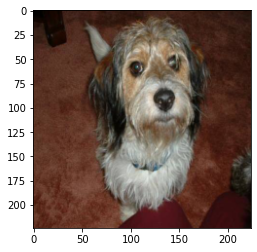

In [ ]:
show_image(*train_dataset.__getitem__(0))

In [ ]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
all_dataset = DogvsCatDataset(train_set+test_set, transform=ImageTransform(size, mean, std), phase='train')
all_dataloader = data.DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

Load model from google drive

In [ ]:
# save to google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/model_ori_trained2.pkl ./

In [ ]:
#load model
net_ori_trained = torch.load('model_ori_trained2.pkl')

In [ ]:
#update_params_name = ['classifier.6.weight', 'classifier.6.bias']
update_params_name = ['features.0.weight', 'features.0.bias','classifier.6.weight', 'classifier.6.bias']

In [ ]:
#model init setting
# Specify The Layers for updating


def model_init(model_, update_params_):
  params_to_update = []

  #TODO: change this to unfreeze the layer

  for name, param in model_.named_parameters():
      if name in update_params_:
          param.requires_grad = True
          params_to_update.append(param)
          print(name)
      else:
          param.requires_grad = False

  return params_to_update

In [ ]:
params_to_update = model_init(net_ori_trained, update_params_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias


In [ ]:
def test_model(net_, dataloader_input):
    

    net_.eval()
        
    epoch_loss = 0.0
    epoch_corrects = 0
    epoch_finish = 0
    
    for _id, (inputs, labels) in enumerate(tqdm(dataloader_input)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()        
        outputs = net_(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data)
        epoch_finish += len(preds)

            
    epoch_loss = epoch_loss / len(dataloader_input.dataset)
    epoch_acc = epoch_corrects.double() / len(dataloader_input.dataset)
    
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [ ]:
test_model(net_ori_trained, test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 0.0347 Acc: 0.9876


In [ ]:
# make the batch size to 1, a new data loader
train_1_dataloader = data.DataLoader(train_dataset, batch_size=1, shuffle=False)
test_1_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)
all_1_dataloader = data.DataLoader(all_dataset, batch_size=1, shuffle=False)

In [ ]:
all_dataset.__len__()

25000

In [ ]:
for name, param in net_ori_trained.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data)

features.0.weight
tensor([[[[-0.5535,  0.1435,  0.5305],
          [-0.5833,  0.3571,  0.7668],
          [-0.6906, -0.0477,  0.4853]],

         [[ 0.1749,  0.0104, -0.0798],
          [ 0.0431, -0.0701, -0.2591],
          [ 0.1310, -0.1728, -0.1311]],

         [[ 0.3109, -0.1666, -0.4272],
          [ 0.4723, -0.0841, -0.4873],
          [ 0.6285,  0.0173, -0.2782]]],


        [[[ 0.2264,  0.1207,  0.1807],
          [-0.4342, -0.2495,  0.2407],
          [-0.2568,  0.1358, -0.0112]],

         [[-0.1453, -0.2234,  0.1466],
          [-0.8458, -0.3562,  0.5598],
          [-0.2465,  0.5149,  0.5349]],

         [[-0.3202, -0.3762, -0.1362],
          [-0.4774, -0.1609,  0.3403],
          [ 0.0483,  0.5808,  0.4899]]],


        [[[ 0.1795,  0.5231,  0.0116],
          [-0.2702, -0.7167,  0.3137],
          [-0.0738, -0.2192,  0.3367]],

         [[ 0.3107,  0.6715,  0.0213],
          [-0.4653, -1.0702,  0.3348],
          [-0.0793, -0.3046,  0.5457]],

         [[ 0.3162,  0.423

In [ ]:
def adversary_gen(model_, dataloader_, eps):
  print("adversary example generation")
  model_.eval()
  loss = nn.CrossEntropyLoss()
  correct = 0
  adv_correct = 0
  total = 0
  diff = 0
  adv_test = 0

  adv_labels = []
  real_labels = []
  noises = []
  model = model_

  index = 0
  index_lst = []

  adv_image_lst = []
  ori_image_lst = []
  adv_label_lst = []
  ori_label_lst = []
  adv_list = []
  ori_prob = []
  adv_prob = []

  for images, labels in dataloader_:  ## Here is the test
    #filename = test_set[index]
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
    results = []
    #with torch.no_grad(): # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/31
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (pre == labels).sum()
    
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    #print(net.classifier[6].weight.grad)
    tmp_noise = images.grad.sign()

    attack_images = images + eps*tmp_noise
    attack_images = torch.clamp(attack_images, 0, 1)

    

    adv_outputs = model(attack_images)
    _, adv_pre = torch.max(adv_outputs.data, 1)
    adv_correct += (adv_pre == labels).sum()
    op_adv_probs = F.softmax(adv_outputs, dim=1)
    op_probs = F.softmax(outputs, dim=1)
    diff += (pre != adv_pre).sum()
    adv_test += ((pre != adv_pre) and (pre == labels)).sum()
    if ((pre != adv_pre) and (pre == labels)) == True:
        ori_image_lst.append(copy.deepcopy(images[0].detach().cpu()))
        adv_image_lst.append(copy.deepcopy(attack_images[0].detach().cpu()))
        ori_label_lst.append(copy.deepcopy(pre[0].detach().cpu()))
        adv_label_lst.append(copy.deepcopy(adv_pre[0].detach().cpu()))
        noises.append(copy.deepcopy(tmp_noise[0].detach().cpu()))

        adv_list.append(index)
        ori_prob.append(copy.deepcopy(op_probs.max().detach().cpu()))
        adv_prob.append(copy.deepcopy(op_adv_probs.max().detach().cpu()))


    # del images, labels, outputs, pre, cost, tmp_noise, attack_images, adv_outputs, adv_pre, op_adv_probs, op_probs
    # torch.cuda.empty_cache()

    if index%10000 == 0:
        print("real case: {}, adv case: {}, diff: {}, total_adv:{}".format(correct/total, adv_correct/total, diff/total, len(adv_list)))
        print(len(adv_image_lst))
        print(torch.cuda.memory_reserved())

    index += 1
  return ori_image_lst, adv_image_lst, noises, ori_label_lst, adv_label_lst, ori_prob, adv_prob, adv_list


In [ ]:
import psutil
print(psutil.cpu_percent(interval=0.5))

1.0


In [ ]:
adv_index_list = {}

In [ ]:
import gc

#eps_list = [ 0.01, 0.007, 0.0001, 0.00001]


t_eps = 0.00001
tmp_name = str(t_eps)
print('current eps: ',tmp_name)
t_ori_image_lst, t_adv_image_lst, t_noises, t_ori_label_lst, t_adv_label_lst, t_ori_prob, t_adv_prob, t_adv_list = adversary_gen(net_ori_trained, all_1_dataloader , t_eps)







current eps:  1e-05
adversary example generation
real case: 1.0, adv case: 1.0, diff: 0.0, total_adv:0
0
6918504448
real case: 0.9866013526916504, adv case: 0.8066193461418152, diff: 0.19018098711967468, total_adv:1851
1851
6924795904
real case: 0.9867506623268127, adv case: 0.8055096864700317, diff: 0.1915404200553894, total_adv:3728
3728
6924795904


In [ ]:
adv_example_dict = {}
adv_example_dict['ori_image'] = t_ori_image_lst
adv_example_dict['adv_image'] = t_adv_image_lst
adv_example_dict['perturbation'] = t_noises
adv_example_dict['ori_label'] = t_ori_label_lst
adv_example_dict['adv_label'] = t_adv_label_lst
adv_example_dict['ori_prob'] = t_ori_prob
adv_example_dict['adv_prob'] = t_adv_prob
adv_example_dict['adv_list'] = t_adv_list

In [ ]:
tmp_train_data = []
for i in range(len(adv_example_dict['adv_image'])):
  tmp_train_data.append([adv_example_dict['adv_image'][i], adv_example_dict['ori_label'][i]])


torch.save(tmp_train_data, 'adv_samples2_eps_'+str(t_eps)+'_pure.pkl')

In [ ]:
num = 190 #adv_example_dict['adv_prob'].index(max(adv_example_dict['adv_prob']))

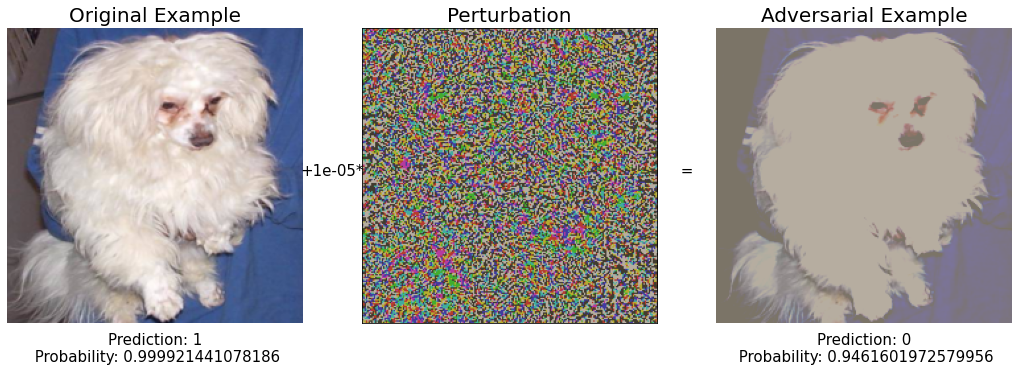

In [ ]:
visualize(adv_example_dict['ori_image'][num], adv_example_dict['perturbation'][num], adv_example_dict['adv_image'][num], t_eps, adv_example_dict['ori_label'][num], adv_example_dict['adv_label'][num], adv_example_dict['ori_prob'][num], adv_example_dict['adv_prob'][num] )

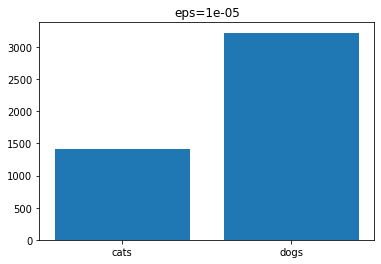

In [ ]:
import numpy
pkl_arr = numpy.array(adv_example_dict['ori_label'])
labels, counts = np.unique(pkl_arr, return_counts=True)
plt.bar(labels, counts, align='center')
my_xticks = ['cats','dogs']
plt.xticks(range(0, 2), my_xticks)
plt.title("eps="+str(t_eps))
plt.show()

In [ ]:
adv_index_list[str(t_eps)] = copy.deepcopy(adv_example_dict['adv_list'])

In [ ]:
len(adv_example_dict['adv_list'])

4631

In [ ]:
#torch.save(adv_example_dict,'adv_samples_eps_'+tmp_name+'_.pkl')

print("before clean up:",int(psutil.virtual_memory().total - psutil.virtual_memory().available))

del t_ori_image_lst, t_adv_image_lst, t_noises, t_ori_label_lst, t_adv_label_lst, t_ori_prob, t_adv_prob, t_adv_list, adv_example_dict, tmp_train_data
gc.collect()

print("after clean up:",int(psutil.virtual_memory().total - psutil.virtual_memory().available))

before clean up: 3777056768
after clean up: 3768631296


In [ ]:
len(adv_index_list)

4

In [ ]:
counter_list = [0] * 25000
for key in adv_index_list:
  print(key)
  for i in range(len(adv_index_list[key])):
    tmp = adv_index_list[key][i]
    counter_list[tmp]+=1



0.01
0.007
0.0001
1e-05


In [ ]:
counter_list_np = numpy.array(counter_list)

In [ ]:
counter_list_np == 4

array([False,  True, False, ..., False, False, False])

In [ ]:
result = numpy.where(counter_list_np == 1)
len(result[0])

3259

In [ ]:
result = numpy.where(counter_list_np == 2)
len(result[0])

2205

In [ ]:
result = numpy.where(counter_list_np == 3)
len(result[0])

1710

In [ ]:
result = numpy.where(counter_list_np == 4)
len(result[0])

2399

In [ ]:
[3259,2205,1710,2399]

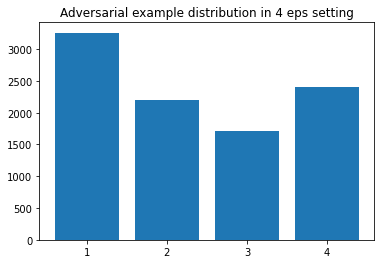

In [ ]:
import numpy
#pkl_arr = numpy.array(counter_list_np)
#labels, counts = np.unique(pkl_arr, return_counts=True)
plt.bar([1,2,3,4],[3259,2205,1710,2399], align='center')
my_xticks = ['1','2', '3', '4']
plt.xticks(range(1, 5), my_xticks)
plt.title("Adversarial example distribution in 4 eps setting")
plt.show()

In [ ]:
result

(array([    0,    10,    21, ..., 24946, 24969, 24994]),)

In [ ]:
adv_index_list.keys()

dict_keys(['0.01', '0.007', '0.0001', '1e-05'])

In [ ]:
import difflib

In [ ]:

sm=difflib.SequenceMatcher(None,adv_index_list['0.01'],adv_index_list['0.007'])
sm.ratio()

0.6917029234409587

In [ ]:
--------------------------------------------------------------

-----------------------------------------------

In [ ]:
import gc

eps_list = [0.1, 0.01, 0.007, 0.001, 0.0001, 0.00001]
adv_example_dict = {}

for i in range(len(eps_list)):
  

  t_eps = eps_list[i]
  tmp_name = str(t_eps)
  print('current eps: ',tmp_name)
  t_ori_image_lst, t_adv_image_lst, t_noises, t_ori_label_lst, t_adv_label_lst, t_ori_prob, t_adv_prob, t_adv_list = adversary_gen(net_ori_trained, all_1_dataloader , t_eps)

  adv_example_dict = {}
  adv_example_dict['ori_image'] = t_ori_image_lst
  adv_example_dict['adv_image'] = t_adv_image_lstminst
  adv_example_dict['perturbation'] = t_noises
  adv_example_dict['ori_label'] = t_ori_label_lst
  adv_example_dict['adv_label'] = t_adv_label_lst
  adv_example_dict['ori_prob'] = t_ori_prob
  adv_example_dict['adv_prob'] = t_adv_prob
  adv_example_dict['adv_list'] = t_adv_list

  torch.save(adv_example_dict,'adv_samples_eps_'+tmp_name+'_.pkl')

  print("before clean up:",int(psutil.virtual_memory().total - psutil.virtual_memory().available))

  del t_ori_image_lst, t_adv_image_lst, t_noises, t_ori_label_lst, t_adv_label_lst, t_ori_prob, t_adv_prob, t_adv_list, adv_example_dict
  gc.collect()

  print("after clean up:",int(psutil.virtual_memory().total - psutil.virtual_memory().available))



current eps:  0.1
adversary example generation
real case: 1.0, adv case: 0.0, diff: 1.0, total_adv:1
1
1828716544
real case: 0.9874012470245361, adv case: 0.5831416845321655, diff: 0.4122587740421295, total_adv:4083
4083
1828716544
real case: 0.9875506162643433, adv case: 0.5835708379745483, diff: 0.4113794267177582, total_adv:8154
8154
1828716544
before clean up: 25433571328
after clean up: 6950772736
current eps:  0.01
adversary example generation
real case: 1.0, adv case: 0.0, diff: 1.0, total_adv:1
1
1828716544
real case: 0.9875012636184692, adv case: 0.7078292369842529, diff: 0.2870712876319885, total_adv:2834
2834
1828716544
real case: 0.9871506094932556, adv case: 0.7081145644187927, diff: 0.2867356538772583, total_adv:5658
5658
1828716544
before clean up: 15961518080
after clean up: 6961938432
current eps:  0.007
adversary example generation
real case: 1.0, adv case: 0.0, diff: 1.0, total_adv:1
1
1828716544
real case: 0.988301157951355, adv case: 0.734526515007019, diff: 0.2605

In [ ]:
curr_eps = 0.00001

tmp_pkl_dict = torch.load('adv_samples_eps_'+str(curr_eps)+'_.pkl')

tmp_train_data = []
for i in range(len(tmp_pkl_dict['adv_image'])):
  tmp_train_data.append([tmp_pkl_dict['adv_image'][i], tmp_pkl_dict['ori_label'][i]])


torch.save(tmp_train_data, 'adv_samples_eps_'+str(curr_eps)+'_pure.pkl')


In [ ]:
tmp_pkl_dict['adv_prob'].index(max(tmp_pkl_dict['adv_prob']))

110

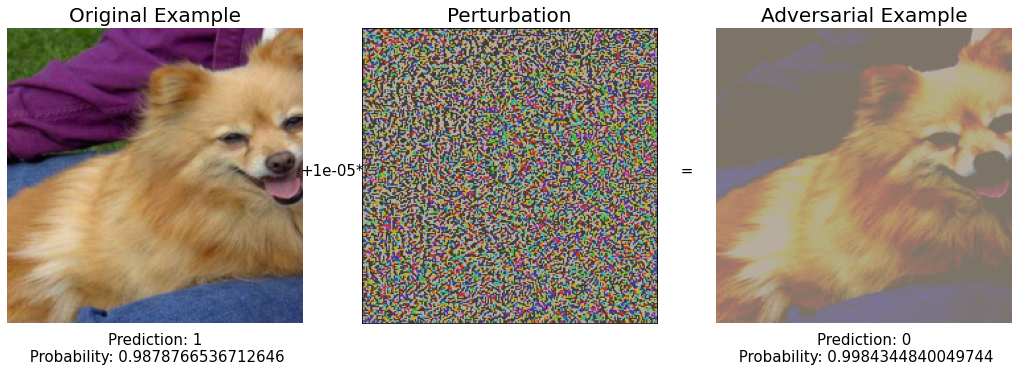

In [ ]:
visualize(tmp_pkl_dict['ori_image'][110], tmp_pkl_dict['perturbation'][110], tmp_pkl_dict['adv_image'][110], curr_eps, tmp_pkl_dict['ori_label'][110], tmp_pkl_dict['adv_label'][110], tmp_pkl_dict['ori_prob'][110], tmp_pkl_dict['adv_prob'][110] )

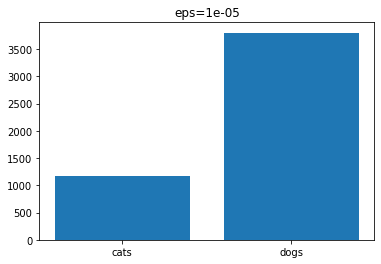

In [ ]:
import numpy
pkl_arr = numpy.array(tmp_pkl_dict['ori_label'])
labels, counts = np.unique(pkl_arr, return_counts=True)
plt.bar(labels, counts, align='center')
my_xticks = ['cats','dogs']
plt.xticks(range(0, 2), my_xticks)
plt.title("eps="+str(curr_eps))
plt.show()

In [ ]:
adv_index_list[str(curr_eps)] = copy.deepcopy(tmp_pkl_dict['adv_list'])

In [ ]:
len(adv_index_list)

2

In [ ]:
import difflib
sm=difflib.SequenceMatcher(None,adv_index_list['0.007'],adv_index_list['1e-05'])

In [ ]:
sm.ratio()

0.6589323098394976

In [ ]:
import gc
del tmp_pkl_dict
gc.collect()

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp *_pure.pkl drive/MyDrive

In [ ]:
import os
os.path.getsize('adv_samples_eps_0.001_.pkl')

9351020228

``` python
print("Attack Image & Predicted Label")
eps = 0.007
net_ori_trained.eval()

loss = nn.CrossEntropyLoss()

correct = 0
adv_correct = 0
total = 0
diff = 0
adv_test = 0

adv_labels = []
real_labels = []
noises = []
model = net_ori_trained

index = 0
index_lst = []

adv_image_lst = []
ori_image_lst = []
adv_label_lst = []
ori_label_lst = []
adv_list = []
ori_prob = []
adv_prob = []



for images, labels in test_1_dataloader:  ## Here is the test
    filename = test_set[index]
    index += 1
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
    results = []
    #with torch.no_grad(): # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/31
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (pre == labels).sum()
    
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    #print(net.classifier[6].weight.grad)
    tmp_noise = images.grad.sign()

    attack_images = images + eps*tmp_noise
    attack_images = torch.clamp(attack_images, 0, 1)

    

    adv_outputs = model(attack_images)
    _, adv_pre = torch.max(adv_outputs.data, 1)
    adv_correct += (adv_pre == labels).sum()
    op_adv_probs = F.softmax(adv_outputs, dim=1)
    op_probs = F.softmax(outputs, dim=1)
    diff += (pre != adv_pre).sum()
    adv_test += ((pre != adv_pre) and (pre == labels)).sum()
    if ((pre != adv_pre) and (pre == labels)) == True:
        ori_image_lst.append(copy.deepcopy(images[0].detach().cpu()))
        adv_image_lst.append(copy.deepcopy(attack_images[0].detach().cpu()))
        ori_label_lst.append(copy.deepcopy(pre[0].detach().cpu()))
        adv_label_lst.append(copy.deepcopy(adv_pre[0].detach().cpu()))
        noises.append(copy.deepcopy(tmp_noise[0].detach().cpu()))

        adv_list.append(filename)
        ori_prob.append(copy.deepcopy(op_probs.max().detach().cpu()))
        adv_prob.append(copy.deepcopy(op_adv_probs.max().detach().cpu()))


    # del images, labels, outputs, pre, cost, tmp_noise, attack_images, adv_outputs, adv_pre, op_adv_probs, op_probs
    # torch.cuda.empty_cache()

    if index%1000 == 0:
        print("real case: {}, adv case: {}, diff: {}, total_adv:{}".format(correct/total, adv_correct/total, diff/total, len(adv_list)))
        print(len(adv_image_lst))
        print(torch.cuda.memory_reserved())

```


In [ ]:
type(adv_image_lst)

list

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 255)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def renormalize(image):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        return image


# images, labels = next(iter(train_dataloader))

# title = 'Dog' if labels[0].item() == 1 else 'Cat'
# imshow(images[0])

def visualize(x, x_noise, x_adv, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.cpu().detach().numpy()
    x = np.transpose(x,(1,2,0))
    #x = np.clip(x, 0, 1)
    x = renormalize(x)

    x_noise = x_noise.cpu().detach().numpy()
    x_noise = np.transpose(x_noise,(1,2,0))
    x_noise = renormalize(x_noise)


    x_adv = x_adv.cpu().detach().numpy()
    x_adv = np.transpose(x_adv,(1,2,0))
    x_adv = renormalize(x_adv)
    
    # x_adv = x_adv.squeeze(0).to('cpu')
    # x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()#reverse of normalization op
    # x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    # x_adv = np.clip(x_adv, 0, 1)
    
    # x_grad = x_grad.squeeze(0).to('cpu').detach().numpy()
    # x_grad = np.transpose(x_grad, (1,2,0))
    # x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Original Example', fontsize=20)
    
    
    ax[1].imshow(x_noise)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,10)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

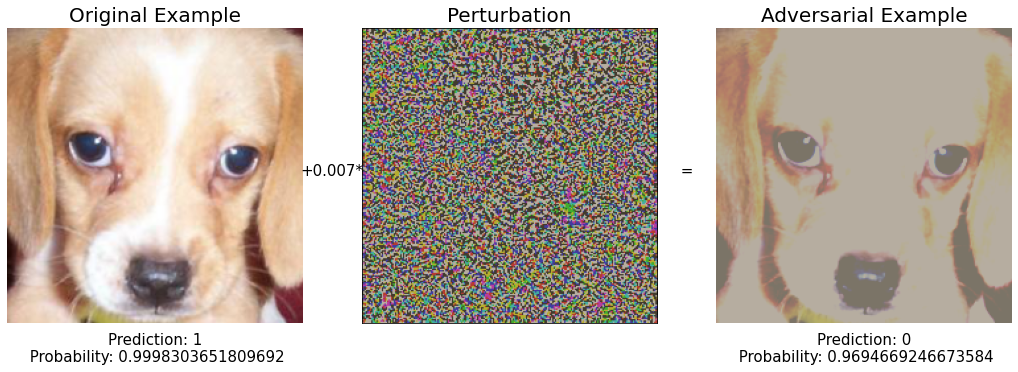

In [ ]:
visualize(ori_image_lst[1], noises[1], adv_image_lst[1], eps, ori_label_lst[1], adv_label_lst[1], ori_prob[1], adv_prob[1] )

In [ ]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Tue May 11 18:57:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   2939MiB / 16280MiB |      0%      Default |
|                               |         

Bulid up dataset with adversarial example

In [ ]:
# adversarial example dataset
adv_train_data = []
for i in range(len(adv_image_lst)):
  adv_train_data.append([adv_image_lst[i], ori_label_lst[i]])


adv_train_dataloader = torch.utils.data.DataLoader(adv_train_data, shuffle=True, batch_size=32)

In [ ]:
i1, l1 = next(iter(adv_train_dataloader))
print(i1.shape)

torch.Size([32, 3, 224, 224])


In [ ]:
i1, l1 = next(iter(train_dataloader))
print(i1.shape)

torch.Size([32, 3, 224, 224])


In [ ]:
test_model(net_ori_trained, adv_train_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 1.4063 Acc: 0.0000


In [ ]:
torch.save(adv_train_data,'test_adv_tmp.pkl')

In [ ]:
tmp_adv = torch.load('test_adv_tmp.pkl')
adv_tmp_dataloader = torch.utils.data.DataLoader(tmp_adv, shuffle=True, batch_size=32)

In [ ]:
adv_tmp_dataloader = torch.utils.data.DataLoader(tmp_adv, shuffle=True, batch_size=32)

In [ ]:
test_model(net_ori_trained, adv_tmp_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 1.4063 Acc: 0.0000


In [ ]:
a = [1,2,3]
c = {}
c['test'] = {}
c['test']['1'] = a

In [ ]:
c['test']['1']

[1, 2, 3]

In [ ]:
a = [2,3,4]

In [ ]:
visualize(ori_image_lst[-2], noises[-2][0], adv_image_lst[-2], eps, ori_label_lst[-2], adv_label_lst[-2], ori_prob[-2], adv_prob[-2] )